# Milestone 2

### Part 1: Getting familiar with the data and constructing the Story Arcs

In this section, we will construct the data pre-processing pipeline for our project. Specifically, we will explore the CMU Movie Corpus dataset by constructing the plot summary data frame and the movie meta data dataframe. 

We will then follow by splitting the movie plot into sentances and perform sentiment analysis on each sentance. With that, we will construct two columns called plot scores and plot classification. The plot scores column contains the list of sentiment scores ranging from (-1: negative) to (+1: positive) while the plot classification column contains the list of sentiment classes taking 3 discrete values (-1: negative), (0: neutral) and (1: positive). 

After performing the previous steps, we can join the two datasets (plot summary, movie meta data) by the wikipedia movie ID. We will then follow by contrsucting 4 different dataframes for the 4 most common genres (Action, Adventure, Comedy and Drama). Now since a movie can have multiple genres, we will make sure that the in constructed dataframes, a movie contain at most one of the four different genres listed. 

Finally, we now have all the needed information to perform clustering on the sentiment time series and with that, we will identify the 3 most common story emotional arcs for each genre. A story emotional arc refers to the plot of the sentiment values over the course of the plot lines which resembles a proxy to the type of events happining in the movies. In a nutshell, this resembles the data-processing pipeline that takes as input the CMU Movie Coprus dataset and outputs the sentiment scores and story emotional arcs of the various movies that we are given.  

#### Part 1.1: Plot Summary dataset (pre-processing + sentiment retrieval)

In [1]:
# Install the necessary libraries
%pip install nltk
%pip install vaderSentiment
%pip install tslearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [60]:
#Imports that are needed for the project
from itertools import zip_longest
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tslearn.clustering import KernelKMeans, TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.barycenters import softdtw_barycenter
from scipy.signal import savgol_filter
import pandas as pd
from nltk import tokenize
import matplotlib.pyplot as plt
from typing import Dict
import json
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [61]:
# Read the Movie Summary Dataset
df_plots = pd.read_csv('MovieSummaries/plot_summaries.txt', sep = '\t', header=None, names = ['id', 'plot'])

# Display the first 5 elements of the dataframe
df_plots.head(5)

,id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [62]:
#Tranform plots into arrays of sentences using the ntlk library
df_plots['plot_sentances']= df_plots['plot'].apply(lambda t: tokenize.sent_tokenize(t))
df_plots.head(2)

,id,plot,plot_sentances
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a hard-working taxi driver and Lyosh..."
1,31186339,The nation of Panem consists of a wealthy Capi...,[The nation of Panem consists of a wealthy Cap...


In [63]:
# instantiate the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# classify the sentiment into one of 3 classes (positive, negative, neutral)
def classify(compound: float):
    if compound >= 0.05:
        #positive
        return 1
    elif compound <= -0.05:
        #negative
        return -1
    #neutral
    return 0

# given a list of sentances, return the result of the analyzer
def analyse_text(paragraph, classify_discrete = True): 
    res = []
    for sentence in paragraph:
        sentiment_result = analyzer.polarity_scores(sentence)
        if classify_discrete:
            res.append(classify(sentiment_result['compound']))
        else:
            res.append(sentiment_result['compound'])
    
    window = int(len(res)/6)
    window = window + 1 if window%2 == 0 else window 
    
    # we utilize a savgol filter, which will smooth the time series (without filtering the resultant time series might be noisy.)
    return savgol_filter(res, window_length=window, polyorder=3) if (not classify_discrete and window>3) else res

In [64]:
# Compute the plot sentitiment discrete classes and continuous scores (the two different columns described previously)
df_plots["plot_classification"] = df_plots["plot_sentances"].apply(lambda t: analyse_text(t))
df_plots["plot_scores"] = df_plots["plot_sentances"].apply(lambda t: analyse_text(t, classify_discrete=False))
df_plots["number_of_sentances"] = df_plots["plot_sentances"].apply(lambda t: len(t))


In [65]:
# display the first 5 elements to view the newly added columns 
df_plots.head(5)

,id,plot,plot_sentances,plot_classification,plot_scores,number_of_sentances
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a hard-working taxi driver and Lyosh...",[0],[0.0083],1
1,31186339,The nation of Panem consists of a wealthy Capi...,[The nation of Panem consists of a wealthy Cap...,"[0, -1, 1, 0, 0, -1, -1, 1, 1, 1, 0, -1, -1, 0...","[-0.22422929292929017, 0.011969191919193323, 0...",52
2,20663735,Poovalli Induchoodan is sentenced for six yea...,[Poovalli Induchoodan is sentenced for six ye...,"[-1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 0, -1, -1...","[-0.8036999999999926, 0.34680000000000144, 0.0...",26
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The Lemon Drop Kid , a New York City swindler...","[-1, 1, 1, -1, -1, 0, 0, 1, -1, -1, 1, 0, -1, ...","[-0.0875818181818192, -0.26741060606060657, -0...",49
4,595909,Seventh-day Adventist Church pastor Michael Ch...,[Seventh-day Adventist Church pastor Michael C...,"[1, 1, 1, -1, 1, 0, -1, 1, -1, -1, -1, 1, -1, ...","[0.4019, 0.0772, 0.2732, -0.6367, 0.4215, 0.0,...",15


#### Part 1.2: Movie Metadata dataset (pre-processing + merging)

In [66]:
# read the movie meta-data dataset
df_metadatas = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t', names=["id", "FreebaseId", "Title", "release date", "boxOffice", "Runtime", "language", "country", "genres"])
df_metadatas.head(5)

,id,FreebaseId,Title,release date,boxOffice,Runtime,language,country,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [67]:
# Merge the two dataframes based on the Movie Wikipedia ID
processed_df = df_metadatas.merge(df_plots, left_on="id", right_on='id')[['id', 'plot', 'release date', 'Title', 'boxOffice', 'plot_classification', 'plot_scores', "country", "genres", "number_of_sentances"]]
processed_df.head(5)

,id,plot,release date,Title,boxOffice,plot_classification,plot_scores,country,genres,number_of_sentances
0,975900,"Set in the second half of the 22nd century, th...",2001-08-24,Ghosts of Mars,14010832.0,"[1, 1, -1, -1, 1, 0, -1, -1, -1, 0, 1, -1, -1,...","[0.2235, 0.144, -0.5423, -0.296, 0.25, 0.0, -0...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",15
1,9363483,A series of murders of rich young women throug...,1987,White Of The Eye,NaN,"[-1, 1, 1, -1, -1, -1, 0, 0, -1, -1, 1, 0, 1, ...","[-0.6641833333333421, 0.3856095238095222, 0.41...","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",36
2,261236,"Eva, an upper class housewife, becomes frustra...",1983,A Woman in Flames,NaN,"[-1, 0, 0, 1, 0, 0, 0, 1, -1, 1, 1, -1, -1, -1...","[-0.7030200000000021, -0.24791999999999947, 0....","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",24
3,18998739,"Every hundred years, the evil Morgana returns...",2002,The Sorcerer's Apprentice,NaN,"[-1, -1, 0, 1, 1, -1, -1]","[-0.836, -0.5106, 0.0, 0.6486, 0.3182, -0.3612...","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",7
4,6631279,"Adam, a San Francisco-based artist who works a...",1997-04-04,Little city,NaN,"[0, -1, 1, 0, -1, -1, 0, 0, -1]","[-0.0258, -0.3612, 0.6705, 0.0, -0.4404, -0.12...","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",9


In [68]:
# count the number of movies that we already have in the dataset after the merge 
initial_size_of_the_dataset = len(processed_df)
print(f"The initial size of the dataset : {initial_size_of_the_dataset}")

# drop the rows that have no box office revenues (we are interrested in the profitability of story arcs)
dropped_processed_df = processed_df.dropna(subset=["boxOffice"])
size_of_the_dataset = len(dropped_processed_df)
print(f"The size of the dataset after removing movies that have no revenue values: {size_of_the_dataset}")

#filter the movies that have plot sentances lower than 5
processed_df = processed_df[processed_df["number_of_sentances"]>5]
size_of_the_dataset = len(processed_df)
print(f"The size of the dataset after removing movies that have plot sentances less than 5: {size_of_the_dataset}")

The initial size of the dataset : 42204
The size of the dataset after removing movies that have no revenue values: 7587
The size of the dataset after removing movies that have plot sentances less than 5: 28033


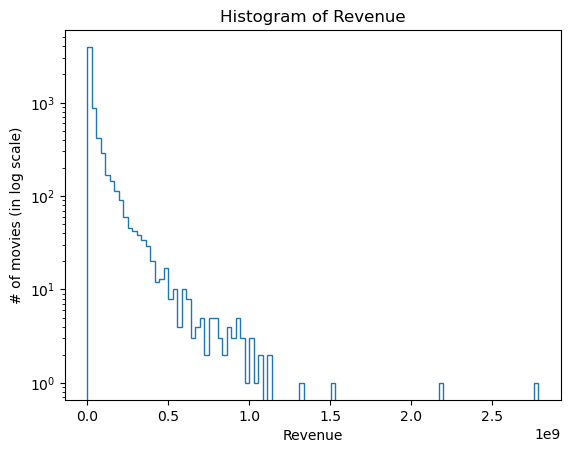

In [69]:
# let us plot the distribution of the box office revenue of different movies
plt.hist(processed_df['boxOffice'],bins=100,log=True,histtype='step')
plt.title('Histogram of Revenue')
plt.ylabel('# of movies (in log scale)')
plt.xlabel('Revenue')
plt.show()

Now since the movie arcs are highly dependant on the genre, we will divide our dataset into 4 different data frames where each data frame contain only the genre that we are interrested in. Yet movies, tend not to belong to only one genre but to multiple genres. Accordingly, we splitted the dataset in a mutually exclusive mannar. Specifically, when we are constructing a dataframe of a genre of interest, we made sure that the choosen movies does not share any other genre of interest besides the constructed one.

In [70]:
genres_of_interest =  ["adventure", "drama", "comedy", "action", "thriller", "science fiction", "costume adventure", "romance comedy"]

# In this part, we create different dataframes for the most common genres (1. Adventure, 2. Action, 3. Drama, 4. Comedy)
def is_needed_genre(genre_movie: Dict[str, str],genres_to_match: str):
        # get list of genres present in the movie
        list_of_genres_in_movie = list(genre_movie.values())

        # get list of genres to discard to avoid duplicates
        genres_to_discard = [genre for genre in genres_of_interest if genre not in genres_to_match]
        
        # flags to be used
        contains_needed_genre = False
        contains_not_needed_genres = False
        
        # iterate over all genres present in the movies
        for genre in list_of_genres_in_movie:
            # check if there is a match
            if (genre.lower() in genres_to_match):
                contains_needed_genre = True
            
            if (genre.lower() in genres_to_discard):
                contains_not_needed_genres = True
        
        # return True only if meets the following criteria
        return (contains_needed_genre) and (not contains_not_needed_genres)

# create column for every genre needed (Here we choose the Top 4 genres present)
processed_df.dropna(subset=['boxOffice'], inplace=True)
processed_df["action"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["action", "thriller"]))
processed_df["adventure"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["adventure", "science fiction", "costume adventure"]))
processed_df["drama"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["drama"]))
processed_df["comedy"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["comedy", "romance comedy"]))

In [71]:
# create the action dataframe
action_df = processed_df[processed_df["action"]].copy().drop(["action", "comedy", "drama", "adventure"], axis=1)

# create the adventure dataframe
adventure_df = processed_df[processed_df["adventure"]].copy().drop(["action", "comedy", "drama", "adventure"], axis=1)

# create the drama dataframe
drama_df = processed_df[processed_df["drama"]].copy().drop(["action", "comedy", "drama", "adventure"], axis=1)

# create the comedy dataframe
comedy_df = processed_df[processed_df["comedy"]].copy().drop(["action", "comedy", "drama", "adventure"], axis=1)

In [72]:
# Let us visualize the size of the constructed dataset
print(f"The size of the action dataset is {len(action_df)}")
print(f"The size of the adventure dataset is {len(adventure_df)}")
print(f"The size of the drama dataset is {len(drama_df)}")
print(f"The size of the comedy dataset is {len(comedy_df)}")

The size of the action dataset is 540
The size of the adventure dataset is 172
The size of the drama dataset is 1314
The size of the comedy dataset is 1005


Now that we have the different dataframes, we can visualize a randomly choosen story arc of a movie for each genre.

Text(0.04, 0.5, 'Sentiment Value')

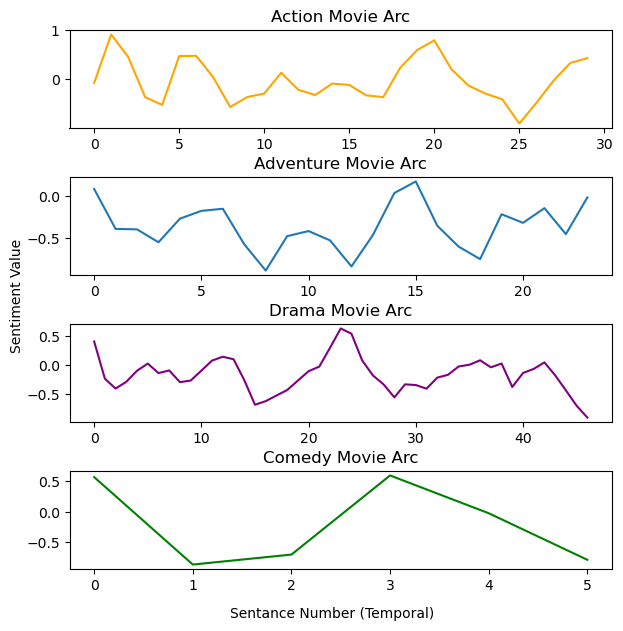

In [73]:
# now let us visualize different movie arcs for each genre (a sample from each)
fig, axis = plt.subplots(4, figsize=(7,7))
# plot the random adventure movie arc
axis[0].plot(list(action_df.iloc[11]["plot_scores"]), color="orange")
axis[0].set_title("Action Movie Arc")

axis[1].plot(list(adventure_df.iloc[10]["plot_scores"]))
axis[1].set_title("Adventure Movie Arc")

axis[2].plot(list(drama_df.iloc[5]["plot_scores"]), color="purple")
axis[2].set_title("Drama Movie Arc")

axis[3].plot(list(comedy_df.iloc[14]["plot_scores"]), color="green")
axis[3].set_title("Comedy Movie Arc")

fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.04, "Sentance Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")

Visualizing one movie is often noisy and not representative, accordingly, we will find the average sentiment score for all the movies in each genre. With that, we compute per index average to account for the fact that different movies have different lengths. 

Text(0.04, 0.5, 'Sentiment Value')

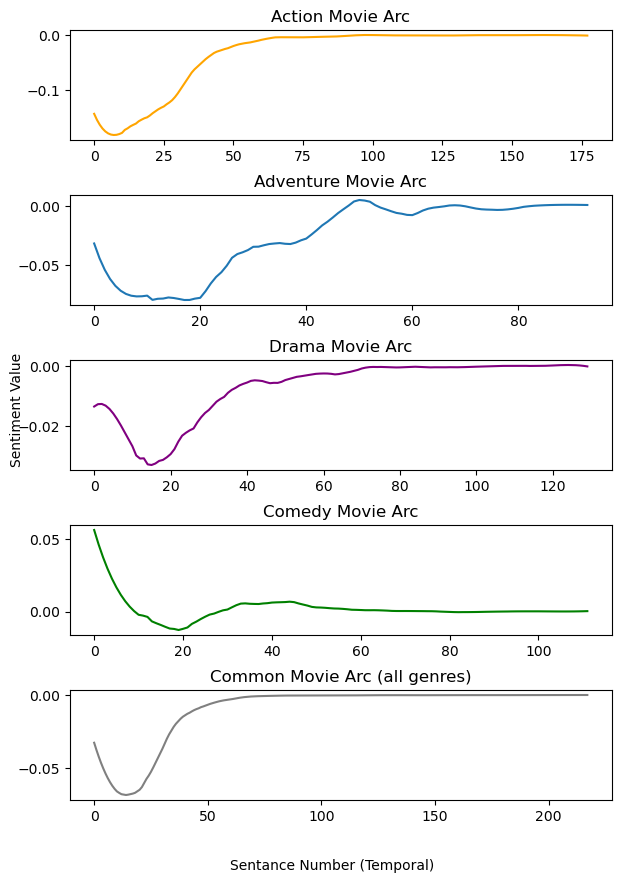

In [74]:
# Visualize the most common movie arc in each genre (by taking average of all the datapoints)
def get_most_common_movie_arc(series_frame):
    dictionary = series_frame.to_dict()
    list_values = [emotional_arc for emotional_arc in dictionary.values()]
    columns = zip_longest(*list_values, fillvalue=0)
    return [sum(col)/len(list_values) for col in columns]     

fig, axis = plt.subplots(5, figsize=(7,10))
# plot the random adventure movie arc
axis[0].plot(savgol_filter(get_most_common_movie_arc(action_df["plot_scores"]), 21,3), color="orange")
axis[0].set_title("Action Movie Arc")

axis[1].plot(savgol_filter(get_most_common_movie_arc(adventure_df["plot_scores"]), 21 ,3))
axis[1].set_title("Adventure Movie Arc")

axis[2].plot(savgol_filter(get_most_common_movie_arc(drama_df["plot_scores"]), 21 ,3), color="purple")
axis[2].set_title("Drama Movie Arc")

axis[3].plot(savgol_filter(get_most_common_movie_arc(comedy_df["plot_scores"]), 21 ,3), color="green")
axis[3].set_title("Comedy Movie Arc")

axis[4].plot(savgol_filter(get_most_common_movie_arc(processed_df["plot_scores"]), 21 ,3), color="gray")
axis[4].set_title("Common Movie Arc (all genres)")

fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.04, "Sentance Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")

In [75]:
def form_features(series_frame):
    dictionary = series_frame.to_dict()
    list_values = [list(emotional_arc) for emotional_arc in dictionary.values() if len(list(emotional_arc))>2]
    return to_time_series_dataset(list_values)

def get_most_common_movie_arc_using_softdtw(series_frame):
    centers =  softdtw_barycenter(form_features(series_frame), max_iter=5)  
    return centers

Text(0.04, 0.5, 'Sentiment Value')

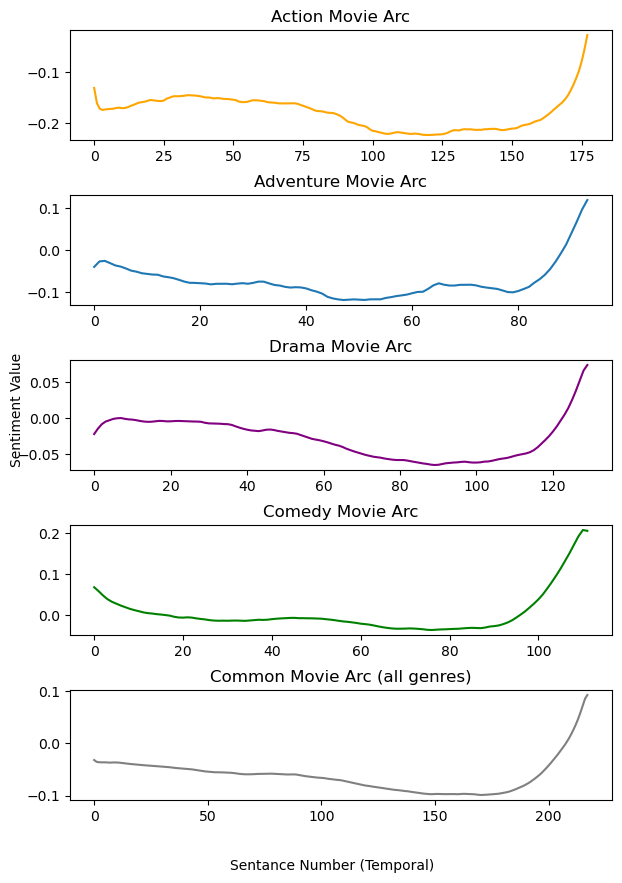

In [76]:
# Averaging using tslearn library
# Visualize the most common movie arc in each genre (by taking average of all the datapoints)

fig, axis = plt.subplots(5, figsize=(7,10))

axis[0].plot(get_most_common_movie_arc_using_softdtw(action_df["plot_scores"]), color="orange")
axis[0].set_title("Action Movie Arc")

axis[1].plot(get_most_common_movie_arc_using_softdtw(adventure_df["plot_scores"]))
axis[1].set_title("Adventure Movie Arc")

axis[2].plot(get_most_common_movie_arc_using_softdtw(drama_df["plot_scores"]), color="purple")
axis[2].set_title("Drama Movie Arc")

axis[3].plot(get_most_common_movie_arc_using_softdtw(comedy_df["plot_scores"]), color="green")
axis[3].set_title("Comedy Movie Arc")

axis[4].plot(get_most_common_movie_arc_using_softdtw(processed_df["plot_scores"]), color="gray")
axis[4].set_title("Common Movie Arc (all genres)")

fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.04, "Sentance Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")

Now that, we have a rough idea about the most representative story arc of each genre, we will cluster the different time series (sentiment scores per plot) into 3 different clusters based on the plot_classification feature of each movie. We believe that utilizing the plot_classification feature (i.e. the discrete class features) is more representative compared to the plot_score feature (i.e. the actual sentiment score ranging from -1 to 1 feature).

In [77]:
# cluster the action genre time series
gak_km = KernelKMeans(n_clusters=3, kernel="gak")
labels_gak = gak_km.fit_predict(form_features(action_df["plot_classification"]))
action_df["cluster_id"] = labels_gak

# cluster the adventure genre time series
gak_km = KernelKMeans(n_clusters=3, kernel="gak")
labels_gak = gak_km.fit_predict(form_features(adventure_df["plot_classification"]))
adventure_df["cluster_id"] = labels_gak

# cluster the drama genre time series
gak_km = KernelKMeans(n_clusters=3, kernel="gak")
labels_gak = gak_km.fit_predict(form_features(drama_df["plot_classification"]))
drama_df["cluster_id"] = labels_gak

# cluster the drama genre time series
gak_km = KernelKMeans(n_clusters=3, kernel="gak")
labels_gak = gak_km.fit_predict(form_features(comedy_df["plot_classification"]))
comedy_df["cluster_id"] = labels_gak

Finally, after performing the clustering, we will view the different time series generated per genre and notice the most common story arcs.

Text(0.02, 0.5, 'Sentiment Value')

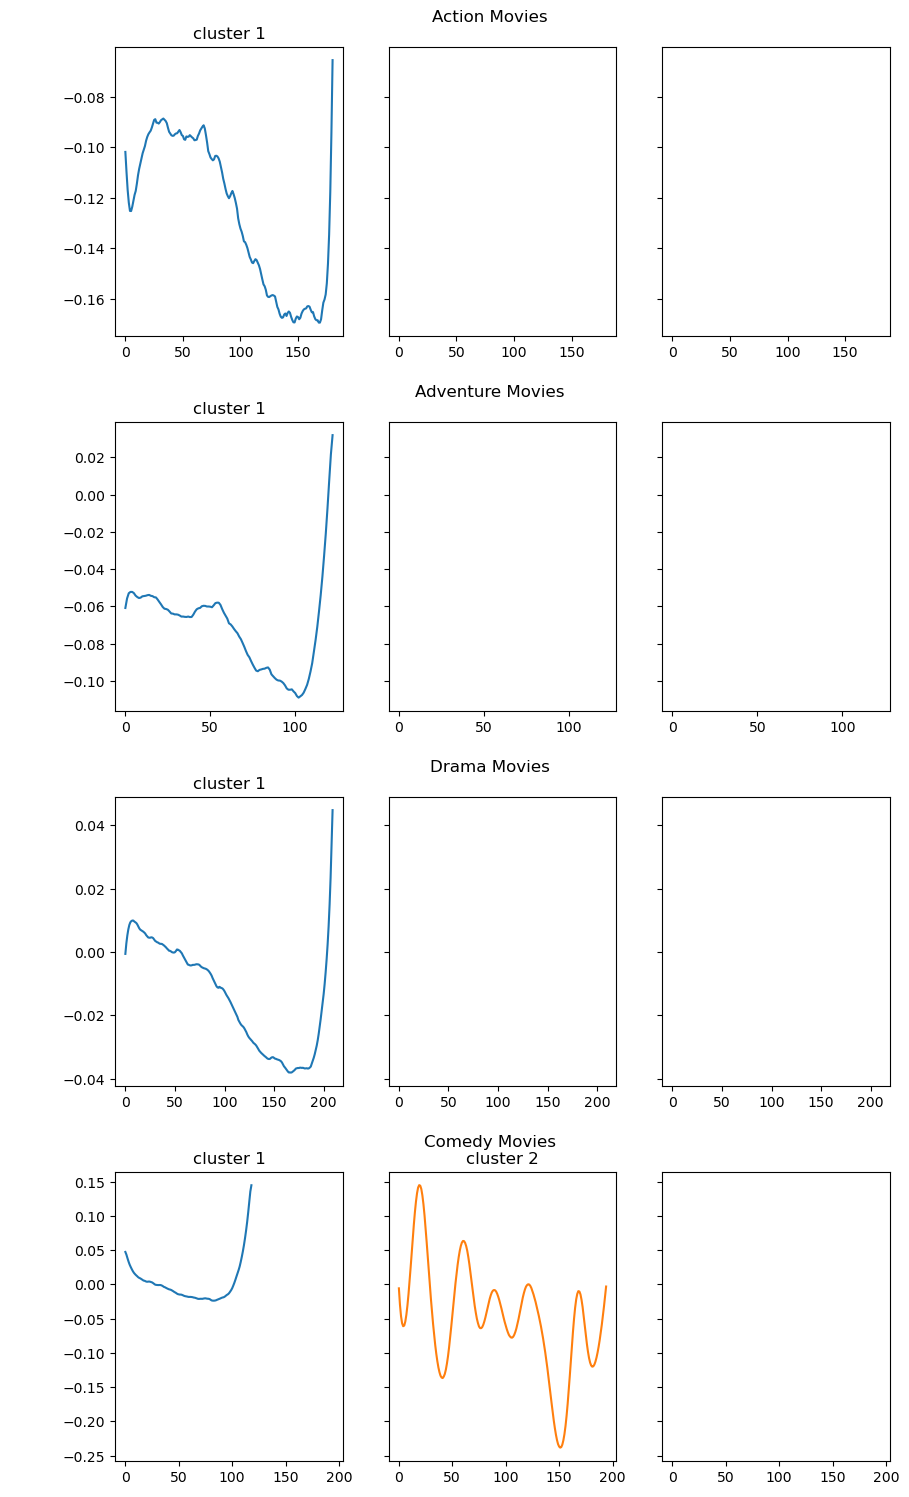

In [22]:
fig = plt.figure(figsize = (10,15))

# form data loader of the different clusters 
dataset_by_genre = {"Action": action_df, "Adventure": adventure_df, "Drama":drama_df, "Comedy":comedy_df}

subfigs = fig.subfigures(nrows=4, ncols=1)
for index, jointed_genres in enumerate(zip(dataset_by_genre.keys(), subfigs)):
    jointed_genres[1].suptitle(f"{jointed_genres[0]} Movies")
    groued_dataset = dataset_by_genre[jointed_genres[0]].groupby("cluster_id")
    colors = plt.rcParams["axes.prop_cycle"]()

    # create 1x3 subplots per subfig
    axs = jointed_genres[1].subplots(nrows=1, ncols=3, sharex=True, sharey=True)
    for key in groued_dataset.groups.keys():

        # get color
        c = next(colors)["color"]
        common_featurs= get_most_common_movie_arc_using_softdtw(groued_dataset.get_group(key)["plot_scores"])

        # filter value
        axs[key].plot(common_featurs, color=c)
        axs[key].set_title(f"cluster {key + 1}")

# common axis label
fig.supxlabel('Sentance Number')
fig.supylabel('Sentiment Value')

To conclude on this part, we were able to construct a data processing pipeline that will allow us to analyze the sentiment of the movies and the various story arcs present in each genre. In Milestone 3, we will perform an in-depth analysis on the choice of clustering algorithms and find the optimal number of clusters that will maximize the inter-class variance and minimize the intra-class variance.  

### Part 2: From the provided dataset to our sicentific question

We'd want to examine and answer many scientific questions now that we've studied and visualized the CMU Corpus dataset. These are the questions:

* What is the effect of the presence of emotions on the success of the movie (Do emotional movies have a higher rating IMDB)? Does the effect differ between genres?

* What is the effect of the positive/negative emotions on the success of the movie (Do movies that are predominently positive (more than 70% of the lines are positive) have a higher IMDB rating? or is the opposite effect true? and do the observed effect vary per genre? 

* What is the most profitable movie arc per genre, is their a clear winner among the various clusters?

* What is the most rated movie per genre, is their a clear winner among the various clusters?

In order to answer the above posed questions, we need to construct the needed dataframes before running any statstical tests to answer our questions. In this section, we will construct the various needed datasets and we will perform the extensive analysis in Milestone 3.

#### Sentiment dataframe

In [23]:
# for each genre, get the negative score, neutral score and positive score
sentiments_df = {"Action": action_df.copy(), "Adventure": adventure_df.copy(), "Drama":drama_df.copy(), "Comedy":comedy_df.copy()}
for dataset in sentiments_df.values():
    # get the negative scores
    dataset["negative_score"] = dataset["plot_classification"].apply(lambda x: np.sum(np.array(x) == -1))

    # get the neutral scores
    dataset["neutral_score"] = dataset["plot_classification"].apply(lambda x: np.sum(np.array(x) == 0))

    # get the positive scores
    dataset["positive_score"] = dataset["plot_classification"].apply(lambda x: np.sum(np.array(x) == 1))

# visualize one the dataframe
sentiments_df['Action'].head()

,id,plot,release date,Title,boxOffice,plot_classification,plot_scores,country,genres,number_of_sentances,cluster_id,negative_score,neutral_score,positive_score
1,9363483,A series of murders of rich young women throug...,1987,White Of The Eye,NaN,"[-1, 1, 1, -1, -1, -1, 0, 0, -1, -1, 1, 0, 1, ...","[-0.6641833333333421, 0.3856095238095222, 0.41...","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",36,0,20,6,10
14,9633533,"Professor Kurian Fernandez , a convict escapes...",1989,Vandanam,NaN,"[1, -1, 1, 0, 1, -1, 0, -1, 1, -1, -1, 1, 0, 0...","[0.07068714285714071, -0.2813485714285713, -0....","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}",33,0,14,8,11
24,4951456,A Japanese businessman sees a woman being grop...,1989,Kinjite: Forbidden Subjects,3416846.0,"[0, 1, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 1, -1]","[0.0, 0.2732, 0.0, -0.5927, 0.0, 0.0, 0.0, 0.0...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",14,0,5,7,2
98,27463222,Paul is a projectionist in a Detroit theater ...,2010-09-12,Vanishing on 7th Street,NaN,"[0, 0, 1, 1, 0, 1, -1, -1, -1, 0, 0, -1, -1, 1...","[-0.011533333333332962, 0.08470000000000037, 0...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",38,0,17,15,6
134,13919299,"An elderly woman, Elmira Johnson, uses a Ouija...",1984,The Devil’s Gift,NaN,"[-1, -1, -1, 1, 0, -1, -1, -1, 0, 1, 1, 0, 0, ...","[-0.4777514285714332, -0.7003942857142866, -0....","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}",29,0,12,10,7


In [24]:
# for each genre, classify the plot as neutral, negative and positive
for dataset in sentiments_df.values():
    # classify 
    dataset.loc[(dataset["neutral_score"]>=0.5*dataset["number_of_sentances"] ),"movie_sentiment"] = 'neutral_movie'
    dataset.loc[(dataset["negative_score"]>=0.5*dataset["number_of_sentances"] ),"movie_sentiment"] = 'negative_movie'
    dataset.loc[(dataset["positive_score"]>=0.5*dataset["number_of_sentances"] ),"movie_sentiment"] = 'positive_movie'

# visualize one the dataframe
sentiments_df['Action'].head()

,id,plot,release date,Title,boxOffice,plot_classification,plot_scores,country,genres,number_of_sentances,cluster_id,negative_score,neutral_score,positive_score,movie_sentiment
1,9363483,A series of murders of rich young women throug...,1987,White Of The Eye,NaN,"[-1, 1, 1, -1, -1, -1, 0, 0, -1, -1, 1, 0, 1, ...","[-0.6641833333333421, 0.3856095238095222, 0.41...","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",36,0,20,6,10,negative_movie
14,9633533,"Professor Kurian Fernandez , a convict escapes...",1989,Vandanam,NaN,"[1, -1, 1, 0, 1, -1, 0, -1, 1, -1, -1, 1, 0, 0...","[0.07068714285714071, -0.2813485714285713, -0....","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}",33,0,14,8,11,NaN
24,4951456,A Japanese businessman sees a woman being grop...,1989,Kinjite: Forbidden Subjects,3416846.0,"[0, 1, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 1, -1]","[0.0, 0.2732, 0.0, -0.5927, 0.0, 0.0, 0.0, 0.0...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",14,0,5,7,2,neutral_movie
98,27463222,Paul is a projectionist in a Detroit theater ...,2010-09-12,Vanishing on 7th Street,NaN,"[0, 0, 1, 1, 0, 1, -1, -1, -1, 0, 0, -1, -1, 1...","[-0.011533333333332962, 0.08470000000000037, 0...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",38,0,17,15,6,NaN
134,13919299,"An elderly woman, Elmira Johnson, uses a Ouija...",1984,The Devil’s Gift,NaN,"[-1, -1, -1, 1, 0, -1, -1, -1, 0, 1, 1, 0, 0, ...","[-0.4777514285714332, -0.7003942857142866, -0....","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}",29,0,12,10,7,NaN


Text(0.0, 0.5, 'Sentiment Value')

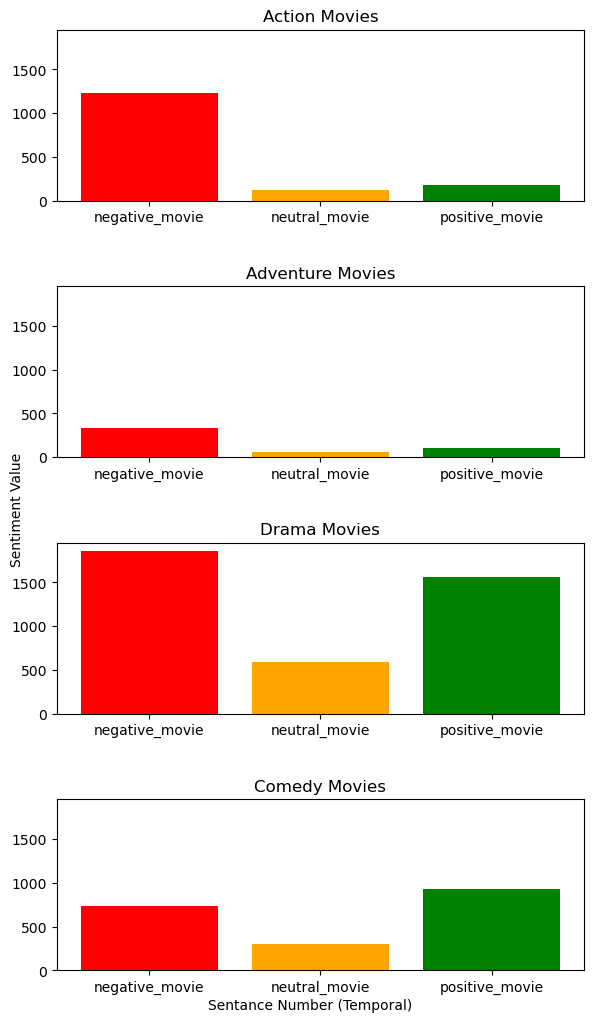

In [28]:
fig, axis = plt.subplots(4, figsize=(6,10), sharey=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"


for index, dataset in enumerate(sentiments_df.keys()):
    df_frame = sentiments_df[dataset].dropna(subset=['movie_sentiment'])
    head = df_frame['movie_sentiment'].value_counts().loc[["negative_movie", "neutral_movie", "positive_movie"]]
    axis[index].bar(head.index, head.values, color=["red", "orange", "green"])
    axis[index].set_title(f"{dataset} Movies")
    
fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.00, "Sentance Number (Temporal)", ha="center")
fig.text(0.0, 0.5, "Sentiment Value", va="center", rotation="vertical")

#### Ratings dataframe

In [29]:
#load the necessary datasets
df_name_basics = pd.read_csv('IMDB/titles.tsv', sep = '\t')

In [30]:
df_ratings = pd.read_csv('IMDB/ratings.tsv', sep = '\t')

In [31]:
#only choose the rows which correspond to a data of a movie
df_title = df_name_basics[df_name_basics['titleType'] == 'movie']

In [32]:
#merge the dataset with the titles and the dataset with the ratings
df_imdb = df_title.merge(df_ratings, left_on='tconst', right_on='tconst')

In [33]:
#create datasets of average ratings of a movie considering the ratings of movies with titles in different language

df_imdb= df_imdb[['originalTitle', 'averageRating', 'numVotes', 'primaryTitle']] #contains all ratings for every movie
df_imdb['multiplication'] = df_imdb['averageRating']*df_imdb['numVotes']
grouped = pd.DataFrame()
grouped['sum_of_mult'] = df_imdb[['originalTitle', 'multiplication']].groupby('originalTitle').sum()
grouped['sum_of_vote'] = df_imdb[['originalTitle', 'numVotes']].groupby('originalTitle').sum()
grouped['average_rating'] = grouped['sum_of_mult']/grouped['sum_of_vote']

grouped = grouped.reset_index(level=0)
grouped.drop(['sum_of_mult'], axis =1).head()

ratings_genre_df = {"Action": pd.DataFrame(), "Adventure": pd.DataFrame(), "Drama":pd.DataFrame(), "Comedy":pd.DataFrame()}
#average ratings for every genre
for dataset in dataset_by_genre.keys():
    ratings_genre_df[dataset] = grouped.merge(dataset_by_genre[dataset], left_on = 'originalTitle', right_on = 'Title')


#### Part 2.1: Emotional vs Non-emotional movies (ratings)

#### Part 2.2: Positive vs Negative movies (ratings)

#### Part 2.3: Most profitable movie arc per genre (box office)

In [35]:
boxOffice_df = processed_df.copy()
boxOffice_df.dropna(subset='boxOffice', inplace=True)
boxOffice_df['country'] = boxOffice_df['country'].apply(lambda d: list(json.loads(d).values()))
boxOffice_df['one'] = boxOffice_df['country'].apply(lambda d: len(d)==1)
boxOffice_df = boxOffice_df[boxOffice_df['one'] ]
boxOffice_df.drop(['one'], axis = 1, inplace=True)
boxOffice_df['country'] = boxOffice_df['country'].apply(lambda d: d[0])
##########
m_df= boxOffice_df.drop(['boxOffice'], axis=1)
m_df = boxOffice_df[['country', 'boxOffice']].groupby('country').transform(lambda x: (x - x.mean()) / x.std()).join(m_df)
m_df.dropna(subset=['boxOffice'], inplace=True)
m_df = m_df[['id', 'boxOffice']]
m_df.shape[0]

4795

In [41]:
m_df.head()
comedy_df[comedy_df['cluster_id'] != 0].head()

,id,plot,release date,Title,boxOffice,plot_classification,plot_scores,country,genres,number_of_sentances,cluster_id
24465,29680525,The film begins with a pre-credits prologue i...,2001-08-30,He Died With A Felafel In His Hand,NaN,"[0, 1, -1, -1, 0, -1, 1, 1, 0, -1, 1, 1, 0, -1...","[0.014357482386893692, -0.021314770605212186, ...","{""/m/03rjj"": ""Italy"", ""/m/0chghy"": ""Australia""...","{""/m/0vgkd"": ""Black comedy"", ""/m/01z4y"": ""Come...",195,1


,cluster_id,release date,boxOffice
0,0,1924.0,-0.479940
1,0,1925.0,-0.471384
2,0,1929.0,-0.465681
3,0,1930.0,-0.485269
4,0,1933.0,-0.474657


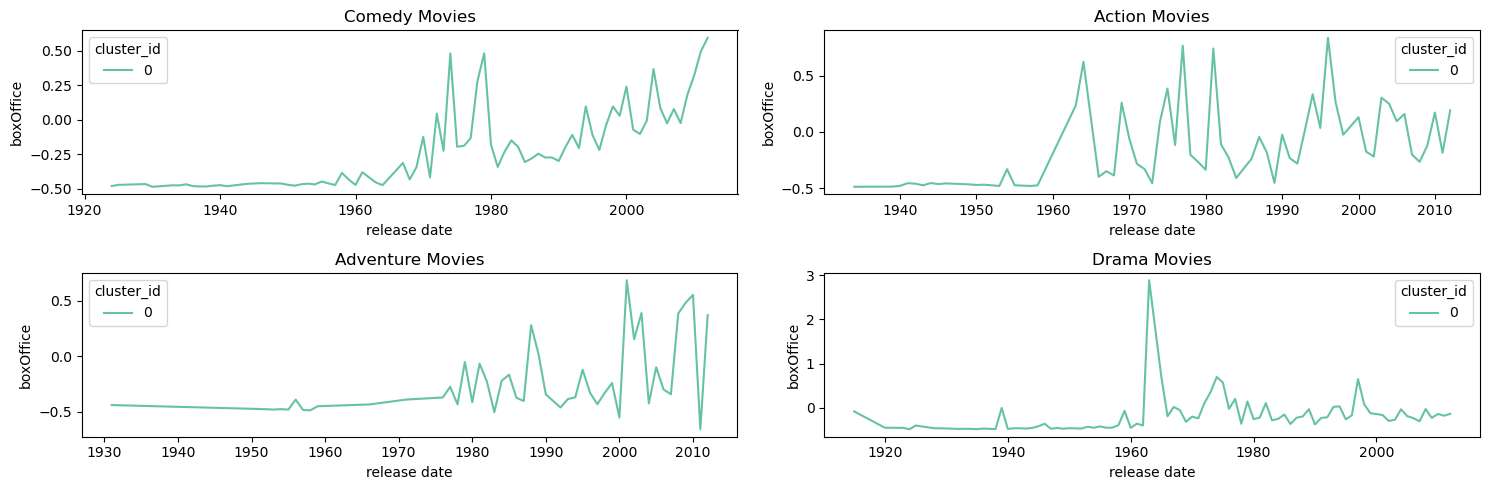

In [39]:
norm_comedy_df = comedy_df.drop(['boxOffice'], axis=1).merge(m_df, left_on='id', right_on='id')
norm_comedy_df['release date'] = pd.to_datetime(norm_comedy_df['release date'])
norm_comedy_df['release date'] = norm_comedy_df['release date'].dt.year
norm_comedy_df = norm_comedy_df[['cluster_id', 'release date', 'boxOffice']].groupby(['cluster_id', 'release date']).mean()

norm_action_df = action_df.drop(['boxOffice'], axis=1).merge(m_df, left_on='id', right_on='id')
norm_action_df['release date'] = pd.to_datetime(norm_action_df['release date'])
norm_action_df['release date'] = norm_action_df['release date'].dt.year
norm_action_df = norm_action_df[['cluster_id', 'release date', 'boxOffice']].groupby(['cluster_id', 'release date']).mean()

norm_adventure_df = adventure_df.drop(['boxOffice'], axis=1).merge(m_df, left_on='id', right_on='id')
norm_adventure_df['release date'] = pd.to_datetime(norm_adventure_df['release date'])
norm_adventure_df['release date'] = norm_adventure_df['release date'].dt.year
norm_adventure_df = norm_adventure_df[['cluster_id', 'release date', 'boxOffice']].groupby(['cluster_id', 'release date']).mean()

norm_drama_df = drama_df.drop(['boxOffice'], axis=1).merge(m_df, left_on='id', right_on='id')
norm_drama_df['release date'] = pd.to_datetime(norm_drama_df['release date'])
norm_drama_df['release date'] = norm_drama_df['release date'].dt.year
norm_drama_df = norm_drama_df[['cluster_id', 'release date', 'boxOffice']].groupby(['cluster_id', 'release date']).mean()

norm_comedy_df.reset_index(inplace=True)
fig, ax = plt.subplots(2,2, figsize=(15, 5))
sns.lineplot(x="release date", y="boxOffice", data=norm_comedy_df, hue="cluster_id",  palette="Set2", ax=ax[0,0])
ax[0,0].set_title("Comedy Movies")
sns.lineplot(x="release date", y="boxOffice", data=norm_action_df, hue="cluster_id",  palette="Set2", ax=ax[0,1])
ax[0,1].set_title("Action Movies")
sns.lineplot(x="release date", y="boxOffice", data=norm_adventure_df, hue="cluster_id",  palette="Set2", ax=ax[1,0])
ax[1,0].set_title("Adventure Movies")
sns.lineplot(x="release date", y="boxOffice", data=norm_drama_df, hue="cluster_id",  palette="Set2", ax=ax[1,1])
ax[1,1].set_title("Drama Movies")
fig.tight_layout()



#### Part 2.4: Most rated movie arc per genre (ratings)

In [ ]:
ratings_genre_df = {"Action": pd.DataFrame(), "Adventure": pd.DataFrame(), "Drama":pd.DataFrame(), "Comedy":pd.DataFrame()}
for dataset in dataset_by_genre.keys():
    ratings_genre_df[dataset] = grouped.merge(dataset_by_genre[dataset], left_on = 'originalTitle', right_on = 'Title')
    ratings_genre_df[dataset] = ratings_genre_df[dataset][ratings_genre_df[dataset]['sum_of_vote'] >= 100][['cluster_id', 'average_rating']].groupby('cluster_id').mean()
    ratings_genre_df[dataset].reset_index(inplace=True)

fig, axs = plt.subplots(2,2, figsize=(6, 7))
j = sns.barplot(x="cluster_id", y="average_rating", data=ratings_genre_df['Action'], ax=axs[0,0], palette="Set2")
j.set_yscale("log")
axs[0,0].set_title("Action Movies")
j = sns.barplot(x="cluster_id", y="average_rating", data=ratings_genre_df['Adventure'], ax=axs[0,1], palette="Set2")
j.set_yscale("log")
axs[0,1].set_title("Adventure Movies")
j = sns.barplot(x="cluster_id", y="average_rating", data=ratings_genre_df['Comedy'], ax=axs[1,0], palette="Set2")
j.set_yscale("log")
axs[1,0].set_title("Comedy Movies")
j = sns.barplot(x="cluster_id", y="average_rating", data=ratings_genre_df['Drama'], ax=axs[1,1], palette="Set2")
j.set_yscale("log")
axs[1,1].set_title("Drama Movies")
fig.tight_layout()